<div align="center"> 
<img src='./img/header.png'/>
</div>

## [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days


---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://staging.nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at uso@nsidc.org


In [1]:
#1: Now let's render our UI and pick up an hemisphere, if you update the hemisphere you need to execute the cell again.
import warnings
warnings.filterwarnings('ignore')
from itslive import itslive_ui
ui = itslive_ui('global')
ui.render()

Dropdown(description='Hemisphere:', options=('global', 'south', 'north'), value='global')

SelectionRangeSlider(description='Date Range', index=(0, 13149), layout=Layout(width='100%'), options=((' 1984…

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [2]:
#2: We build the parameters to query the ITS_LIVE Search API, we get the time coverage for our selected area
params = ui.build_params()
print(f'current parameters: {params}')
timeline = None
if params is not None:
    timeline = ui.update_coverages()
    total =  sum(item['count'] for item in timeline)
    print(f'Total data granules: {total:,}')
timeline

current parameters: {'polygon': '-49.5551,69.1349,-49.5551,69.1369,-49.5531,69.1369,-49.5531,69.1349,-49.5551,69.1349', 'start': '1984-01-01', 'end': '2020-01-01', 'percent_valid_pixels': '90', 'time_delta': '67'}
Total data granules: 604


[{'count': 1, 'year': 1988},
 {'count': 4, 'year': 1989},
 {'count': 4, 'year': 1992},
 {'count': 3, 'year': 1993},
 {'count': 1, 'year': 2003},
 {'count': 39, 'year': 2013},
 {'count': 48, 'year': 2014},
 {'count': 67, 'year': 2015},
 {'count': 83, 'year': 2016},
 {'count': 182, 'year': 2017},
 {'count': 172, 'year': 2018}]

In [3]:
#4: Now we are going to get the velocity pair urls, this does not download the files yet just their location
params = ui.build_params()
if params is not None:
    urls = ui.get_granule_urls()
    # Print the first 10 granule URLs
    for url in urls[0:10]:
        print(url)

{'url': 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_008012_20140509_20170422_01_T1_X_LC08_L1TP_008012_20140322_20170424_01_T1_G0240V01_P095.nc'}
{'url': 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_008012_20140509_20170422_01_T1_X_LC08_L1TP_008012_20140407_20170424_01_T1_G0240V01_P095.nc'}
{'url': 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_008012_20150512_20170409_01_T1_X_LC08_L1TP_008012_20150426_20170409_01_T1_G0240V01_P093.nc'}
{'url': 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_008012_20170415_20170501_01_T1_X_LC08_L1TP_008012_20170226_20170316_01_T1_G0240V01_P095.nc'}
{'url': 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_009012_20180730_20180814_01_T1_X_LC08_L1TP_009012_20170711_20170711_01_RT_G024

In [4]:
#5: This will query AWS(where the granules are stored) so we know the total size of our first N granules
# This may take some time, try reducing the selected area or constraining the other parameters to download a reasonable number of granules.
url_list = [url['url'] for url in urls]
# urls
filtered_urls = ui.filter_urls(url_list, max_files_per_year=4, months=[2,3,4,5,6,7,8,9])

# max_granules = 100
# sizes = ui.calculate_file_sizes(filtered_urls, max_granules)
# total_zise = round(sum(sizes)/1024,2)
# print(f'Approx size to download for the first {max_granules:,} granules: {total_zise} MB')
print(len(filtered_urls))
filtered_urls

26


['http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_008012_20150512_20170409_01_T1_X_LC08_L1TP_008012_20150426_20170409_01_T1_G0240V01_P093.nc',
 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_008012_20170415_20170501_01_T1_X_LC08_L1TP_008012_20170226_20170316_01_T1_G0240V01_P095.nc',
 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_009012_20180730_20180814_01_T1_X_LC08_L1TP_009012_20170711_20170711_01_RT_G0240V01_P092.nc',
 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32623/LC08_L1TP_007012_20150825_20170405_01_T1_X_LC08_L1TP_007012_20150708_20170407_01_T1_G0240V01_P098.nc',
 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32623/LC08_L1TP_007012_20170627_20170627_01_RT_X_LC08_L1TP_007012_20170510_20170516_01_T1_G0240V01_P091.nc',
 'http://its-live-da

## Downloading the data
**Now that we have our list of data granules we can download them from AWS.**

If this notebook is running inside AWS we could load the granules into a Dask cluster and reduce our processing times and costs.
Let's get some coffee, some data requests are in the Gigabytes realm and may take a little while to be processed. 
Once that your status URL says is completed we can grab the HDF5 data file using the URL on the same response!

In [5]:
# This will download the first 50 velocity pairs
files = ui.download_velocity_pairs(filtered_urls, start=0, end=50)
files

['LC08_L1TP_009012_20180730_20180814_01_T1_X_LC08_L1TP_009012_20170711_20170711_01_RT_G0240V01_P092.nc',
 'LC08_L1TP_008012_20170415_20170501_01_T1_X_LC08_L1TP_008012_20170226_20170316_01_T1_G0240V01_P095.nc',
 'LC08_L1TP_007012_20170627_20170627_01_RT_X_LC08_L1TP_007012_20170510_20170516_01_T1_G0240V01_P091.nc',
 'LC08_L1TP_007012_20150825_20170405_01_T1_X_LC08_L1TP_007012_20150708_20170407_01_T1_G0240V01_P098.nc',
 'LC08_L1TP_007012_20170729_20170730_01_RT_X_LC08_L1TP_007012_20170627_20170714_01_T1_G0240V01_P097.nc',
 'LC08_L1TP_007012_20170729_20170730_01_RT_X_LC08_L1TP_007012_20170627_20170627_01_RT_G0240V01_P097.nc',
 'LC08_L1TP_007012_20180918_20180918_01_RT_X_LC08_L1TP_007012_20180902_20180912_01_T1_G0240V01_P091.nc',
 'LC08_L1TP_008012_20150512_20170409_01_T1_X_LC08_L1TP_008012_20150426_20170409_01_T1_G0240V01_P093.nc',
 'LC08_L1TP_009011_20130411_20170505_01_T1_X_LC08_L1TP_011011_20130322_20170505_01_T1_G0240V01_P092.nc',
 'LC08_L1TP_009011_20130427_20170505_01_T1_X_LC08_L1TP_

## Working with the data

In [6]:
import os
import glob
import xarray as xr
import pyproj
import warnings
import pandas as pd
import numpy as np
from datetime import datetime
warnings.filterwarnings('ignore')
coord = ui.dc.last_draw['geometry']['coordinates']
# coord = [-49.59321, 69.210579]
#loads an array of xarray datasets from the nc files
velocity_pairs = ui.load_velocity_pairs('data')

In [7]:
velocities = []
for ds in velocity_pairs:
    proj = str(int(ds.UTM_Projection.spatial_epsg))
    selected_coord = ui.transform_coord('4326',proj, coord[0], coord[1])
    lon = round(selected_coord[0])
    lat = round(selected_coord[1])
    mid_date = datetime.strptime(ds.img_pair_info.date_center,'%Y%m%d')
    # Is this correct? 1000 in UMT will be 1.2km?
    mask_lon = (ds.x >= lon - 1200) & (ds.x <= lon + 1200)
    mask_lat = (ds.y >= lat - 1200) & (ds.y <= lat + 1200)
    # gives us 6 to 9 points to "average" here we need some sort of weighted average
    v = ds.where(mask_lon & mask_lat , drop=True).v.mean(skipna=True)
    # If we have a valid value we add it to the velocities array.
    if not np.isnan(v):
        velocities.append({'date': mid_date, 'mean_velocity': v.values.ravel()[0]})


In [8]:
import pandas as pd
# order by date
df = pd.DataFrame.from_dict(velocities)
df

,date,mean_velocity
0,2013-03-30,10474.101562
1,1989-04-18,4531.538574
2,1989-04-18,4545.862305
3,2015-05-10,9383.977539
4,1989-04-14,5687.419922
5,2017-03-22,7865.904297
6,2015-04-09,9612.329102
7,2003-04-09,7753.330078
8,2015-05-04,9456.179688
9,2013-04-07,10614.330078


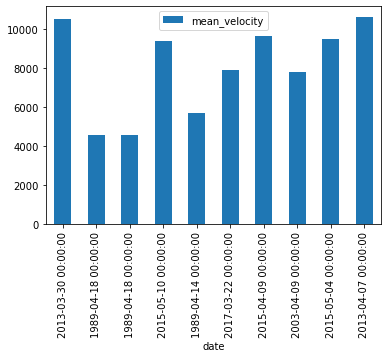

In [14]:
df.plot(x ='date', y='mean_velocity', kind = 'bar')

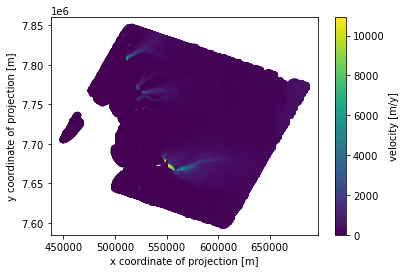

In [17]:

velocity_pairs[15].plot.scatter(x='x', y='y', hue='v')

In [ ]:
ds_cube.sel(time=0)

In [ ]:
ui.dc.last_draw['geometry']['coordinates']